In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [2]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float64, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  
obs = simulator.sample(1)

In [3]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
d_marker = 'd' if glob_det == 'det' else 's'
# s_marker = '_asymL2'
# m_marker = '_m1' # m0 - plain, m1 - learns binwise mu, m2 - learns theta 
# netid = p_marker+b_marker+d_marker+str(train_bounds)+s_marker+m_marker
netid = p_marker+b_marker+d_marker+str(train_bounds)

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

/tmp/ipykernel_1472626/600084491.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


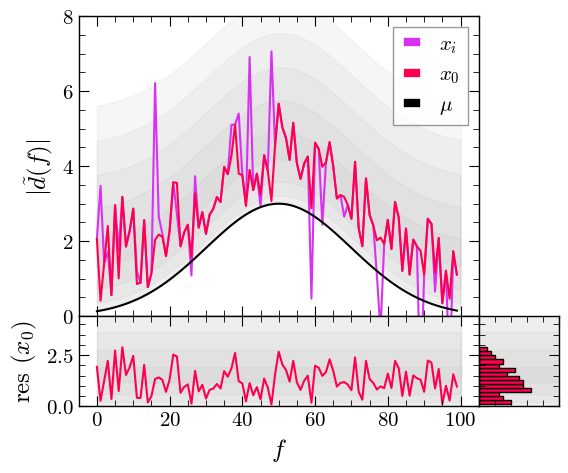

In [4]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

quantiles = np.array([5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()

In [5]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_Mu(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0)

        self.mu_predictor = torch.nn.Sequential(
            torch.nn.Linear(Nbins, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, Nbins)
        )

    def mu(self, x):
        x = self.mu_predictor(x.unsqueeze(1)).squeeze(1)
        return x
    
    # def epsilon(self, x):
        # x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        # return x
    
    # def snr(self, x):
        # return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    # def forward(self, x):
        
    #     # Adaptive data generation
    #     ni = x['ni']
    #     epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
    #     data =  x['x0'] + epsilon_sim * ni
        
    #     # data = x['x']
    #     epsilon = self.epsilon(data)
    #     mask = ( x['ni'] != 0 )  
    #     squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
    #     l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
    #     return (l * mask.float()).sum() * 0.5

    def forward(self, x):

        # Data generation #

        # generate a noise block like x #
        x_shape = x['x0'].shape # [nsims,nbins]
        noise = torch.complex(torch.randn(x_shape).cuda(), torch.randn(x_shape).cuda()).cuda()
        norm_noise = torch.abs(noise)

        # generate some epsilon #
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni

        # generate a mu block like x #
        m, amp, sigma = [Nbins/2,3,20]
        grid = torch.arange(Nbins).cuda()
        mu = amp * torch.exp(-0.5 * ((grid - m) / sigma) ** 2)
        mu_block = (torch.ones(x_shape).cuda())*mu.unsqueeze(0)

        stoch_mu  = mu_block+norm_noise+epsilon_sim

        # gen net # 
        net_mu = self.mu(stoch_mu)

        # evaluate #
        error = (net_mu-mu)**2
        l = error / (self.logvariance.exp() + 1e-10) + self.logvariance 
        return l.sum() * 0.5
        

In [20]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    # sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_mu = Network_Mu()
model = CustomLossModule_withBounds(network_mu, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_mu.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Network_Mu | 108 K  | train
---------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.435     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
/opt/ioa/software/anaconda3/envs/python-3.11-2023-12a/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = 

Training: |          | 0/? [00:00<?, ?it/s]

/opt/ioa/software/anaconda3/envs/python-3.11-2023-12a/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
`Trainer.fit` stopped: `max_epochs=20` reached.


In [23]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        resd = x - network_mu.mu(x.unsqueeze(1)).squeeze(1)
        out = self.net(resd.unsqueeze(1)).squeeze(1) # x-net
        return out
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        
        ###########################################
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, 
                                                           device= x['x'].device, 
                                                           dtype= x['x'].dtype) - self.bounds()) * ni
        ###########################################
        
        data =  x['x0'] + epsilon_sim * ni
        
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [24]:
# # Train
# def resample(sample):
#     sample = simulator._resample(sample)
#     sample['x'] = sample['xi']
#     # sample = {k: v[0] for k, v in sample.items()}
#     return sample

batch_size = 124
samples = simulator.sample(Nsims=Nsims)  

# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)

network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Network_epsilon | 66.5 K | train
--------------------------------------------------
66.5 K    Trainable params
0         Non-trainable params
66.5 K    Total params
0.266     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/opt/ioa/software/anaconda3/envs/python-3.11-2023-12

Training: |          | 0/? [00:00<?, ?it/s]

/opt/ioa/software/anaconda3/envs/python-3.11-2023-12a/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
`Trainer.fit` stopped: `max_epochs=20` reached.


In [25]:
torch.save(network_epsilon, f'networks/network_eMu_{netid}_complex')
torch.save(model, f'networks/model_eMu_{netid}_complex')

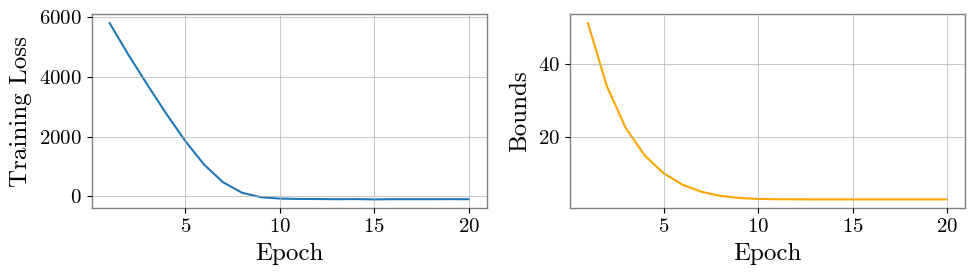

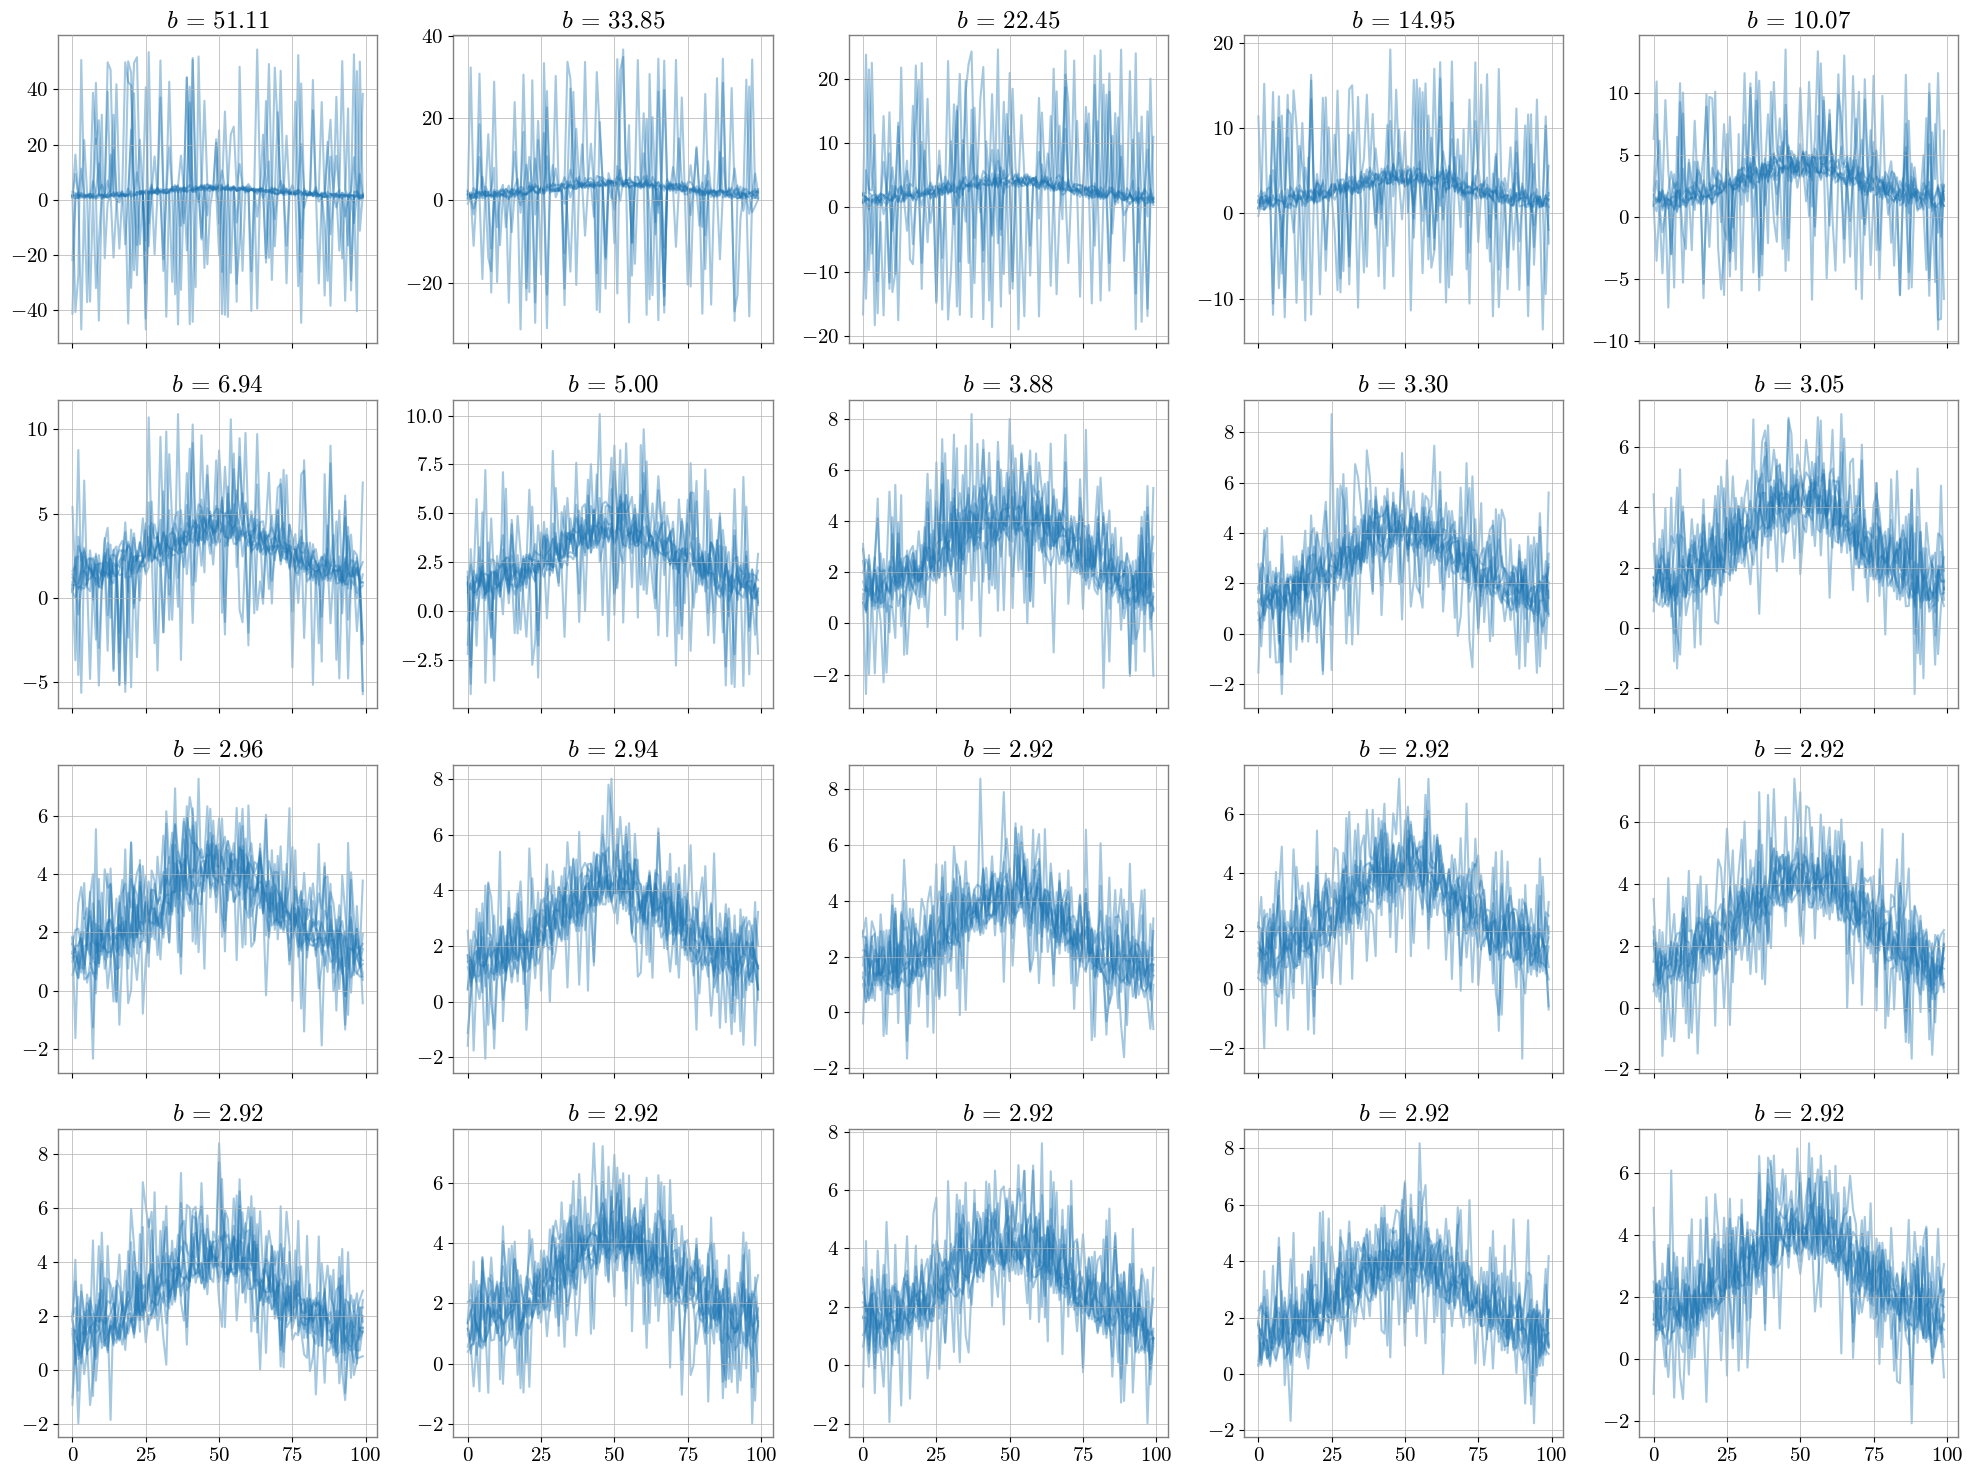

In [26]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout()
plt.savefig(f'figs/{netid}/bounds.png', dpi=300)
plt.tight_layout();

# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            # axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout()
# plt.savefig(f'figs/{netid}/history.png', dpi=300)


In [27]:
network_epsilon.cuda()
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)

ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)


100%|██████████| 488/488 [01:18<00:00,  6.21it/s]


In [28]:
def pvalue_grid_eps(dat):
    eps_t_mean = np.mean(ts_bin_H0_epsilon, axis=0)
    eps_t_ref = ts_bin_H0_epsilon - eps_t_mean
    counts = np.sum(eps_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(eps_t_ref) + 1)

def pvalue_grid_BCE(dat):
    BCE_t_mean = np.mean(ts_bin_H0_BCE, axis=0)
    BCE_t_ref = ts_bin_H0_BCE - BCE_t_mean
    counts = np.sum(BCE_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(BCE_t_ref) + 1)

def chop_middle(array, remove=5, linemode=True):
    if len(array)%2==0:
        mid_u = int(len(array)/2)
        mid_d = mid_u -1
        if not linemode:
            return np.concatenate([array[:mid_d-remove], array[mid_u+remove:]])
        else:
            return array[:mid_d-remove] , array[mid_u+remove:], array[mid_u]
    else:
        mid = len(array)//2
        if not linemode:
            return np.concatenate([array[:mid-remove], array[mid+remove:]])
        else:
            return array[:mid-remove], array[mid+remove:], array[mid]
        
def get_snr2(input:dict):
    target = input['x']
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy()**2 
    return snr2_nn

def local_do_ticks(list_of_axes, dir = 'in'):
    for ax in list_of_axes:
        ax.minorticks_on()
        ax.tick_params(top=True,right=True, direction=dir, length=7, which='major')
        ax.tick_params(top=True,right=True, direction=dir, length=4, which='minor')

def local_fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def local_fix_plot(a, tickdir ='in'):
    for axes in a:
        axes.grid(False)
        local_do_ticks([axes], tickdir)
        local_fix_frame(axes)
    return True

/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1452163/754178201.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


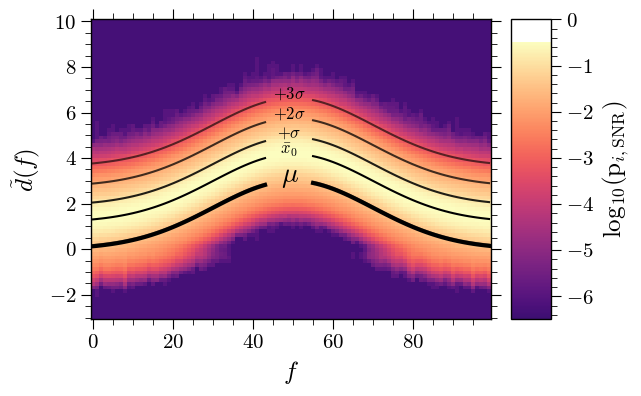

In [29]:
###### SET UP GRID ######
positions = torch.arange(0, Nbins, 1).to(dtype=simulator.dtype)
amplitudes = torch.linspace(-3, 10, 80).to(dtype=simulator.dtype)

position_grid, amplitude_grid = torch.meshgrid(positions,amplitudes)
b = {'x':amplitude_grid.T}

###### DO BCE STATS ######
a = b['x']
s = get_snr2(b)
dat = [a,s]


fig, ax1 = pf.create_plot()
ax1.set_xlabel(r'$f$')
ax2 = fig.add_axes((1.05, 0,0.1,1))

# ax3 = fig.add_axes((0, 1.1,1,1))
# plt.setp(ax3.get_xticklabels(), visible=False)
# ax4 = fig.add_axes((1.05, 1.1,0.1,1))

axs = [ax1,ax2]


dat = [pvalue_grid_eps(s)]
lab =  [r'$\mathrm{log}_{10}($p$_{i, \mathrm{SNR}})$']

labcolour = "#000000"


for q in range(1):
    mesh = axs[2*q].pcolormesh(position_grid.T, amplitude_grid.T, np.log10(dat[q]), cmap='magma', vmin=-8)
    fig.colorbar(mesh,cax=axs[2*q+1], shrink=0.8, label=lab[q])
    axs[2*q+1].set_ylim([-6.5,0])

    for j in range(2):
        axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0])[j], color=labcolour, linewidth=3)
        for i in range(5):
            alp = .5+(i/8)
            axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0]+quantiles[-i])[j], color=labcolour, alpha=alp)

    x = 47
    axs[2*q].text(x,obs['mu'][0][int(x)], r'$\mu$', color=labcolour, size=20)
    sigs = [r'$+3\sigma$',r'$+2\sigma$',r'$+\sigma$',r'$\bar{x}_0$']
    x2 = 49
    ff = torch.Tensor([0,0,0,-1])
    for i in range(1,5):
        axs[2*q].text(x2,(obs['mu'][0]+quantiles[-i])[int(x2)], sigs[i-1], color=labcolour, size=12, ha='center')  

    axs[2*q].set_ylabel(r'$\tilde{d}(f)$')

local_fix_plot(axs, tickdir='out')

plt.tight_layout()
plt.savefig(f'figs/{netid}/pmaps.png', dpi=700, bbox_inches = 'tight')
